In [2]:
from pathlib import Path
import sys

helper_utils = Path.cwd() / "utils"
sys.path.append(str(helper_utils))

import utils 
import shutil
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Faculty of Science and Engineering 🔬
The University of Manchester 
Invoking utils version: 0.7.0


# Convolutional Neural Networks (CNNs)

In mathematics, convolution refers to an operation that slides one function over another and measures their pointwise multiplication. In deep learning, convolutional layers use cross-correlations that are similar to convolutions.

Convolutional layers are the blocks of Convolutional Neural Networks (CNNs), they contain neurons that are not fully connected to each pixel. Instead, they are connected only to pixels in their respective field. This means that the next Convolutional layer will focus on an even smaller set of pixels.

**CNNs seek to sort out and learn the most important patterns in an image**. So even though there might be less trainable parameters in a CNN when compared to a traditional DNN, these are often more helpful in deciphering between different the different **features** present in an image.

The aforementioned peculiarity of convolutional layers allows CNNs to focus on fine low-level features in the first hidden layer, then combine them into higher-level features in the next hidden layer and so on. For this reason, CNNs perform extremely well in image recognition tasks.

> **Note**: In literature, you will often find people referring to filters as kernels.

Let's take a look at how convlution work using a simple example.

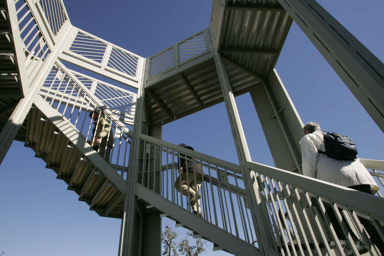

In [3]:
asc_image = Path.cwd() / "figs" / "ascent.jpg"
asc_image = Image.open(asc_image).resize((768//2, 512//2))
asc_image

## The Convolution Operation
The convolution operation will effectively modify the size of image due to not using any kind of `padding` method. 

> We'll explore padding later on this tutorial, but for now we'll keep things simple.

This method can be used to apply the convolution operation to the images, and visualize the results. It will take the input image and the convolutional filters as arguments, and return the convolved images. We will also add a visualization option to compare the original image with the convolved image.

First, we need to be able to compute the output of the convolved image.

In [4]:
def compute_convolution_size(img_size: tuple, 
                            kernel_size: int,
                            padding: int = 0,
                            stride: int = 1) -> tuple:
    """
    Compute the output size of an image being transformed
    through the convolution process

    Args:
        img_size (tuple): Size of the input image (height, width)
        kernel_size (int): 
            Size of the filter. It is assumed the kernel is square
        padding (int, optional): Size of convolution padding. Defaults to 0.
        stride (int, optional): Size of stride. Defaults to 1.

    Returns:
        tuple: 
            Output size (height, width) after convolution
    """
    img_height, img_width = img_size
    output_height = int((img_height - kernel_size + 2*padding)/stride + 1)
    output_width = int((img_width - kernel_size + 2*padding)/stride + 1)
    return output_height, output_width

# Example using asc_image dimensions
output_size = compute_convolution_size(asc_image.size, kernel_size=3, padding=1)
print(f"Original size: {asc_image.size[0]}x{asc_image.size[1]}")
print(f"After convolution: {output_size[0]}x{output_size[1]}")


Original size: 384x256
After convolution: 384x256


The convolution function can be implemented by extracting a 3x3 pixel subset to a separate matrix, and then performing an element-wise multiplication between the image subset and the filter. The results are then summed. Let's explore how this works computationally by processing a single 3x3 subset of our image.

In [5]:
# Get a subset sample of our image using
# a 3x3 kernel
kernel_shape = [3,3]
img_subset = np.array(asc_image)[0:kernel_shape[0],0:kernel_shape[1]]
img_subset

array([[[18, 21, 10],
        [19, 22, 11],
        [15, 18,  7]],

       [[19, 23, 12],
        [21, 24, 13],
        [22, 25, 14]],

       [[18, 24, 12],
        [19, 25, 13],
        [18, 24, 12]]], dtype=uint8)

### Filters for Convolutional Layers
Convolutional layers require the user to determine the number of filters (kernels) that should be used. In practice, these filters are a collection of detectors that can detect basic patterns, such as edges and corners, in the early layers of the network. As one goes deeper into the network, more intricate patterns can be recognized, like the patterns that define a human or a horse (depending on the dataset). This capability of the convolutional layers to detect complex patterns from the input data is what makes them so useful and effective in computer vision tasks.

A single filter can be represented as a small, usually rectangular matrix. The dimensions of the matrix must be determined, with 3x3 and 5x5 being good choices for starters. The entries of the filter matrix are initialized with random values that the neural 
network must learn to optimize, based on the dataset provided.

Let's define some common filters to test our convolution method.

> The following filters are well known for image operations, you can explore more of these kernels [here](https://en.wikipedia.org/wiki/Kernel_(image_processing))

In [6]:
sharpen_filter = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

blur_filter = np.array([
    [0.0625, 0.125, 0.0625],
    [0.125,  0.25,  0.125],
    [0.0625, 0.125, 0.0625]
])

outline_filter = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

Now, we just need to multiply the desired filter to our image subset, and sum the matrix to obtain a new single pixel value

In [7]:
# First the matrix multiplication
filtered = img_subset * sharpen_filter
filtered

array([[[  0, -21,   0],
        [-19, 110, -11],
        [  0, -18,   0]],

       [[  0, -23,   0],
        [-21, 120, -13],
        [  0, -25,   0]],

       [[  0, -24,   0],
        [-19, 125, -13],
        [  0, -24,   0]]])

In [8]:
# Final step is to sum the whole matrix
conv_subset = np.sum(filtered, axis=(1,2)) # We use axis 1 and 2 to sum the rows and columns
print(f"Our convolved subset would produce a single pixel with value {conv_subset}")

Our convolved subset would produce a single pixel with value [41 38 45]


Let's define a function that will take an image and a filter as input, and return the convolved image

In [9]:
def convolve(img: np.array, kernel: np.array) -> np.array:
    """
    Convolve a 2D/3D image with a 2D kernel.

    Args:
         img (np.array): The image to be convolved (grayscale or RGB).
         kernel (np.array): The convolution kernel.
    Returns:
        np.array: Convolved resized image with same number of channels as input
    """
    # Handle RGB (3D) vs grayscale (2D) images
    is_rgb = len(img.shape) == 3
    
    if is_rgb:
        img_height, img_width, channels = img.shape
    else:
        img_height, img_width = img.shape
        channels = 1
        
    kernel_size = kernel.shape[0]
    target_size = compute_convolution_size(
        (img_height, img_width),
        kernel_size=kernel_size
    )
    
    # Initialize output array with appropriate dimensions
    if is_rgb:
        output_array = np.zeros((*target_size, channels))
    else:
        output_array = np.zeros(target_size)
        
    # Process each channel separately for RGB images
    for c in range(channels):
        for ix in range(target_size[0]):
            for jx in range(target_size[1]):
                if is_rgb:
                    img_subset = img[ix:ix+kernel_size, jx:jx+kernel_size, c]
                    output_array[ix, jx, c] = np.sum(np.multiply(img_subset, kernel))
                else:
                    img_subset = img[ix:ix+kernel_size, jx:jx+kernel_size]
                    output_array[ix, jx] = np.sum(np.multiply(img_subset, kernel))
                    
    return output_array

In [10]:
sharpen_asc = convolve(np.array(asc_image), sharpen_filter)
blurred_asc = convolve(np.array(asc_image), blur_filter)
outline_asc = convolve(np.array(asc_image), outline_filter)

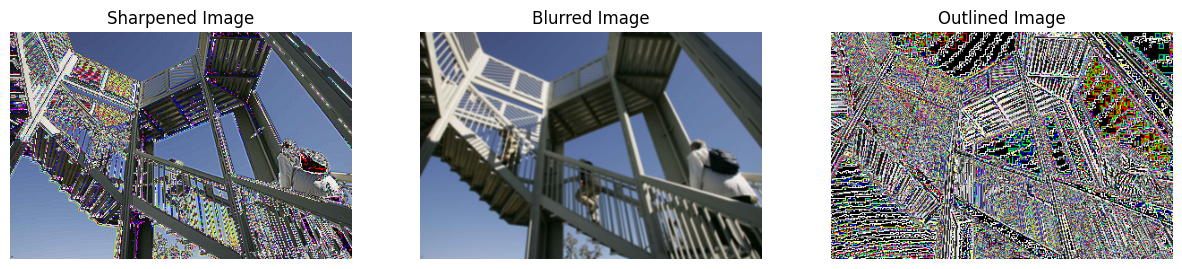

In [11]:
sharp_img = Image.fromarray(sharpen_asc.astype(np.uint8))
blur_img = Image.fromarray(blurred_asc.astype(np.uint8))
outline_img = Image.fromarray(outline_asc.astype(np.uint8))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(sharp_img)
axes[0].set_title("Sharpened Image")
axes[0].axis('off')
axes[1].imshow(blur_img)
axes[1].set_title("Blurred Image")
axes[1].axis('off')
axes[2].imshow(outline_img)
axes[2].set_title("Outlined Image")
axes[2].axis('off')
plt.show()

## Convolutions in PyTorch
PyTorch provides a built-in function to perform convolutions, which is much more efficient than implementing it manually. The `torch.nn.Conv2d` class is used to create a convolutional layer in PyTorch. It takes several parameters:
- `in_channels`: The number of input channels (e.g., 3 for RGB images).
- `out_channels`: The number of output channels (i.e., the number of filters).
- `kernel_size`: The size of the filter (e.g., 3 for a 3x3 filter).
- `stride`: The step size for moving the filter across the image (default is 1).
- `padding`: The amount of zero-padding added to the input image (default is 0).

The way PyTorch handles images is by using a 4D tensor with the shape `(batch_size, channels, height, width)`. The `Conv2d` layer will take this tensor as input and apply the convolution operation to it. Thus, we need to reshape our image to fit this format.

In [12]:
# Check the shape of the image
np.array(asc_image).shape

(256, 384, 3)

In [13]:
# Change the shape of the image to (C, H, W)
torch_asc = torch.from_numpy(np.array(asc_image)).permute(2,0,1)
torch_asc = torch_asc.unsqueeze(0).float() # Add batch dimension
torch_asc.shape

torch.Size([1, 3, 256, 384])

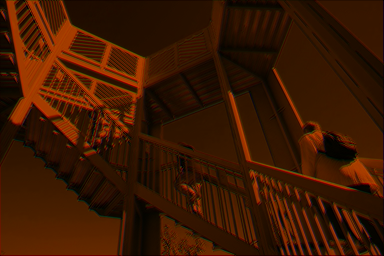

In [14]:
conv2d = torch.nn.Conv2d(
    in_channels=3, 
    out_channels=3, 
    kernel_size=3, 
    stride=1, 
    padding=1, 
)

conv2d.eval()
filtered_asc = conv2d(torch_asc)
# Reverse the transformation to get back to (H, W, C)
filtered_asc = filtered_asc.squeeze(0).detach().numpy().transpose(1, 2, 0)
# Make sure the values are in the range [0, 255]
# and convert to uint8 for PIL
filtered_asc = np.clip(filtered_asc, 0, 255).astype(np.uint8) 
filtered_asc_img = Image.fromarray(filtered_asc)
filtered_asc_img

## Padding and Stride
Padding is the process of adding extra pixels around the border of an image. This is done to control the spatial dimensions of the output feature map. By adding padding, we can ensure that the output size remains the same as the input size, which is useful when we want to maintain the spatial dimensions throughout the network.

Stride is the step size for moving the filter across the image. A stride of 1 means that the filter moves one pixel at a time, while a stride of 2 means that it moves two pixels at a time. Increasing the stride reduces the spatial dimensions of the output feature map, which can be useful for downsampling.

In [15]:
data_path = Path.cwd() / "datasets"
dataset_path = utils.download_dataset("historical cracks",
                                   dest_path=data_path,
                                   extract=True,
                                remove_compressed=True)

Downloading:
Historical-crack18-19: A dataset of annotated images for non-invasive surface crack detection in historical buildings
> Authors: Esraa Elhariri, Nashwa El-Bendary, Shereen Taie
> Year: 2020
> Website: https://www.sciencedirect.com/science/article/pii/S2352340922000774#fig0001



Extracting Historical Building Cracks.zip: 100%|██████████| 3899/3899 [00:01<00:00, 1951.28it/s]


In [16]:
main_data_path = list(dataset_path.glob("*"))[0]
images = list(main_data_path.rglob("*.jpg"))

In [17]:
rnd_ix = random.randint(0, len(images) - 1)
img = Image.open(images[rnd_ix])
img.size

(256, 256)

(128, 128)


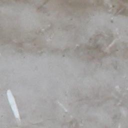

In [18]:
img = img.resize((128, 128))
print(img.size)
img

## The convolution operation

How do convolutions work? This is a common operation in image processing, where a filter is applied to an image to change its underlying characteristics.

Let’s take the pixels in an image as an example. We will analyse each pixel by taking its value and looking at its neighbours. A 3x3 filter can be compared to its immediate neighbour, so a 3x3 grid would be generated. By multiplying each neighbour by the corresponding value in the filter, we get the new value for the pixel.

(100, 100)


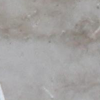

In [19]:
img_ctr_x = img.size[0] // 2
img_ctr_y = img.size[1] // 2

cropped = img.crop((img_ctr_x - 50, img_ctr_y - 50, img_ctr_x + 50, img_ctr_y + 50))
print(cropped.size)
cropped

In [20]:
from torchvision import transforms

ts = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.CenterCrop((100, 100)),
    transforms.ToTensor(),
])

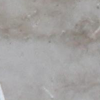

In [21]:
img_tensor = ts(img)
img_tensor.shape

# display the tensor as an image with PIL
img_tensor_pil = transforms.ToPILImage()(img_tensor)
img_tensor_pil

In [22]:
img_crack = main_data_path / "crack"
img_no_crack = main_data_path / "non-crack"

# The no crack images are not balanced with the crack images
# Let's balance them by taking a random sample of the no crack images
crack_images = list(img_crack.glob("*.jpg"))
no_crack_images = list(img_no_crack.glob("*.jpg"))
no_crack_images = random.sample(no_crack_images, len(crack_images))

len(crack_images), len(no_crack_images)


(757, 757)

In [23]:
# Create a new folder for the balanced dataset
balanced_data_path = main_data_path / "balanced"
balanced_data_path.mkdir(parents=True, exist_ok=True)
crack_folder = balanced_data_path / "crack"
crack_folder.mkdir(parents=True, exist_ok=True)
no_crack_folder = balanced_data_path / "no_crack"
no_crack_folder.mkdir(parents=True, exist_ok=True)
# Copy the crack images to the balanced folder
for img in crack_images:
    shutil.copy(img, crack_folder / img.name)
# Copy the no crack images to the balanced folder
for img in no_crack_images:
    shutil.copy(img, no_crack_folder / img.name)


In [24]:
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder

ts = transforms.Compose([
    transforms.Resize((64, 64)),
    # transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

data = ImageFolder(balanced_data_path, transform=ts)
targets = data.targets
data.classes

['crack', 'no_crack']

In [25]:
from sklearn.model_selection import train_test_split
train_ix, val_ix = train_test_split(
    torch.arange(len(targets)),
    test_size=0.1,
    shuffle=True,
    random_state=42,
    )
val_ix, test_ix = train_test_split(
    val_ix,
    test_size=0.5,
    shuffle=True,
    random_state=42,
    )

In [26]:
train_sampler = torch.utils.data.SubsetRandomSampler(train_ix)
val_sampler = torch.utils.data.SubsetRandomSampler(val_ix)
test_sampler = torch.utils.data.SubsetRandomSampler(test_ix)

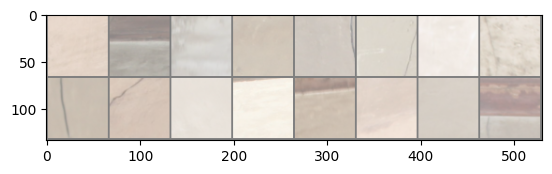

tensor([1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0])


In [27]:
# visualize the first image in the dataset
import matplotlib.pyplot as plt
import torchvision
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
loader = DataLoader(data, batch_size=16, sampler=test_sampler,
                    generator=torch.Generator().manual_seed(42))
dataiter = iter(loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(labels)

In [28]:
train_dl = DataLoader(data, batch_size=64, sampler=train_sampler,
                      generator=torch.Generator().manual_seed(42))
val_dl = DataLoader(data, batch_size=64, sampler=val_sampler,
                     generator=torch.Generator().manual_seed(42))
test_dl = DataLoader(data, batch_size=64, sampler=test_sampler,
                      generator=torch.Generator().manual_seed(42))

In [29]:
images[0].max(), images[0].min()

(tensor(0.8431), tensor(0.4863))

In [30]:
class simpleCNN(torch.nn.Module):
    def __init__(self, n_classes):
        super(simpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3,  16, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(16 * 64 * 64, 16)
        self.fc2 = torch.nn.Linear(16, n_classes)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = x.view(-1, 16 * 64 * 64)  # Flatten the tensor
        x = torch.nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_v1 = simpleCNN(len(data.classes))
criterion = torch.nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model_v1.parameters(), lr=5e-3)
num_epochs = 20

simpleCNN Training:   0%|          | 0/20 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

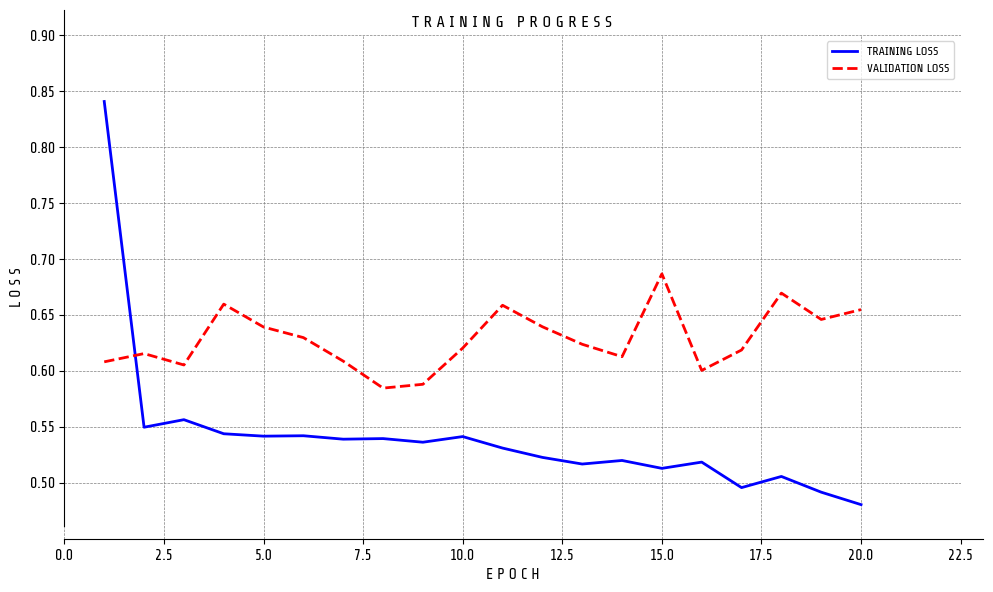

In [31]:
model_v1 = utils.train_model(model_v1,
                             criterion,
                             optimiser,
                             train_loader=train_dl,
                             val_loader=val_dl,
                             num_epochs=num_epochs,
                             plot_loss=True)

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_v1.eval()
with torch.no_grad():
    for images, labels in test_dl:
        outputs = model_v1(images.to(device))
        print(outputs[:-1])
        _, predicted = torch.max(outputs, 1)
        print(predicted)
        break

tensor([[ -0.4923,   0.7875],
        [ -0.4899,   0.7428],
        [ -0.7696,   1.0879],
        [ -0.3810,   0.5231],
        [ -0.5263,   0.7801],
        [ -0.5860,   0.9578],
        [ -0.4718,   0.7061],
        [ -0.7093,   0.6083],
        [ -0.5249,   0.8689],
        [ -3.2823,   2.2296],
        [ -0.4602,   0.7502],
        [ -0.6402,   1.0390],
        [ -0.6703,   1.0855],
        [ -0.4272,   0.7320],
        [ -0.5311,   0.8827],
        [ -0.5482,   0.8989],
        [ -0.6013,   0.9765],
        [ -0.4521,   0.7622],
        [-12.9521,   8.4690],
        [ -1.4620,   1.0131],
        [ -0.6937,   0.7727],
        [ -1.0221,   0.7470],
        [ -0.6224,   1.0153],
        [ -0.5094,   0.8329],
        [ -1.0913,   0.7792],
        [ -0.6259,   1.0169],
        [ -0.6038,   0.7748],
        [ -0.5252,   0.8737],
        [ -0.8558,   0.7684],
        [ -0.5152,   0.8606],
        [ -0.5830,   0.9599],
        [ -0.4920,   0.8003],
        [ -0.4714,   0.7787],
        [ 

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def compute_accuracy(model, test_dataloader):
    model.eval()
    acc = 0.0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device).type(torch.long)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            acc += utils.accuracy_score(labels, predicted)

    return acc / len(test_dataloader)



In [34]:
compute_accuracy(model_v1, test_dl)

0.6860119047619048

In [35]:
from sklearn.metrics import classification_report

test_labels = []
test_preds = []

model_v1.eval()
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device).type(torch.long)
        outputs = model_v1(images)
        _, predicted = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())
print(classification_report(test_labels, test_preds, target_names=data.classes))

              precision    recall  f1-score   support

       crack       1.00      0.04      0.07        52
    no_crack       0.68      1.00      0.81       104

    accuracy                           0.68       156
   macro avg       0.84      0.52      0.44       156
weighted avg       0.78      0.68      0.56       156



## Regularisation methods
When using convolutional neural networks, we can use regularisation methods to prevent overfitting and to stabilise the training process. The most common regularisation methods are:
- **Dropout**: Randomly sets a fraction of input units to 0 at each update during training time, which helps prevent overfitting.
- **L2 regularisation**: Adds a penalty on the size of the weights to the loss function. This is also known as weight decay.
- **Batch Normalisation**: Normalises the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation. This helps to stabilise the learning process and can lead to faster convergence.
- **Data augmentation**: Increases the diversity of the training set by applying random transformations to the input data, such as rotation, translation, and scaling. This helps to improve the generalisation of the model.

In [36]:
class tinyVGG(torch.nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.flat = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(64 * 64 * 64, 128)
        self.fc2 = torch.nn.Linear(128, n_classes)
        # dropout for regularization
        self.dropout1 = torch.nn.Dropout(p=0.05)
        self.dropout2 = torch.nn.Dropout(p=0.1)
        # batch normalization for more stable training
        self.batch_norm1 = torch.nn.BatchNorm2d(16, momentum=0.8)
        self.batch_norm2 = torch.nn.BatchNorm2d(32, momentum=0.8)
        self.batch_norm3 = torch.nn.BatchNorm2d(64, momentum=0.8)

    def forward(self, x):
        x = self.dropout1(torch.nn.functional.relu(self.batch_norm1(self.conv1(x))))
        x = self.dropout1(torch.nn.functional.relu(self.batch_norm2(self.conv2(x))))
        x = self.dropout1(torch.nn.functional.relu(self.batch_norm3(self.conv3(x))))
        x = self.flat(x)
        x = self.dropout2(torch.nn.functional.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [37]:
# torch.cuda.empty_cache()
# model_v2 = regularizedCNN(len(data.classes))
model_v2 = tinyVGG(len(data.classes))
criterion_reg = torch.nn.CrossEntropyLoss()
optimiser_reg = torch.optim.Adam(model_v2.parameters(),
                                 lr=1e-3,
                                 betas=(0.9, 0.999),
                                #  weight_decay=1e-5,  # L2 regularization (weight decay)
                                 ) 
num_epochs_reg = 45
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimiser_reg,
    mode='min',
    factor=0.1,
    patience=2,
)

tinyVGG Training:   0%|          | 0/45 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Training Batch 0/44:   0%|          | 0/44 [00:00<?, ?it/s]

Validation Batch 0/3:   0%|          | 0/3 [00:00<?, ?it/s]

Early stopping at epoch 18
Best model saved at c:\Users\Corona\Documents\Git\UoM_fse_dl_workshop\my_models\model_v2.pt


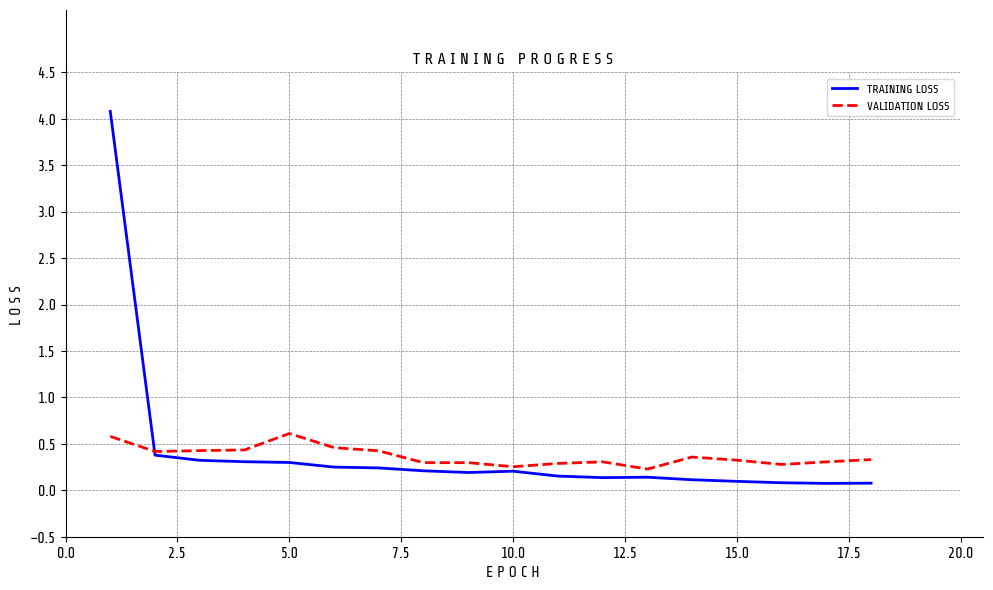

In [38]:
model_v2 = utils.train_model(model_v2,
                  criterion_reg,
                  optimiser_reg,
                  train_loader=train_dl,
                  val_loader=val_dl,
                  num_epochs=num_epochs_reg,
                  early_stopping=True,
                  patience=5,
                  tolerance=1e-2,
                  save_path= Path.cwd() / "my_models" / "model_v2.pt",
                  plot_loss=True)

In [39]:
# Load the best model
model_v2.load_state_dict(torch.load(Path.cwd() / "my_models" / "model_v2.pt"))
compute_accuracy(model_v2, test_dl)

0.9136904761904763

In [40]:
from sklearn.metrics import classification_report, confusion_matrix

test_labels = []
test_preds = []

model_v2.eval()
with torch.no_grad():
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device).type(torch.long)
        outputs = model_v2(images)
        _, predicted = torch.max(outputs, 1)
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(predicted.cpu().numpy())
print(classification_report(test_labels, test_preds, target_names=data.classes))

              precision    recall  f1-score   support

       crack       0.87      0.87      0.87        52
    no_crack       0.93      0.93      0.93       104

    accuracy                           0.91       156
   macro avg       0.90      0.90      0.90       156
weighted avg       0.91      0.91      0.91       156

